In [ ]:
!pip install -q ultralytics
!pip install -q mediapipe opencv-python

In [2]:
import cv2
import numpy as np
import mediapipe as mp
from ultralytics import YOLO
import matplotlib.pyplot as plt

In [3]:
model = YOLO('/kaggle/input/yolov8l/best.pt')

In [4]:
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=True, min_detection_confidence=0.5)

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1747226169.044166     391 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747226169.102516     391 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


In [15]:
def draw_boxes(image, results):
    h, w, _ = image.shape
    scale_factor = max(w, h) / 1000

    for r in results:
        for box in r.boxes:
            cls = int(box.cls[0])
            conf = float(box.conf[0])
            xyxy = box.xyxy[0].cpu().numpy().astype(int)
            label = model.names[cls]

            cv2.rectangle(image, tuple(xyxy[:2]), tuple(xyxy[2:]), (0, 255, 0), 2)

            font_scale = 0.5 * scale_factor
            thickness = int(1.5 * scale_factor)
            cv2.putText(image, f"{label} {conf:.2f}", (xyxy[0], xyxy[1] - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, font_scale, (0, 0, 0), thickness)
    return image


In [16]:
def compute_iou(box1, box2):
    x1, y1, x2, y2 = box1
    x1_p, y1_p, x2_p, y2_p = box2
    xi1 = max(x1, x1_p)
    yi1 = max(y1, y1_p)
    xi2 = min(x2, x2_p)
    yi2 = min(y2, y2_p)
    inter_area = max(0, xi2 - xi1) * max(0, yi2 - yi1)
    box1_area = (x2 - x1) * (y2 - y1)
    box2_area = (x2_p - x1_p) * (y2_p - y1_p)
    union_area = box1_area + box2_area - inter_area
    return inter_area / union_area if union_area != 0 else 0

def point_in_box(point, box):
    x, y = point
    x1, y1, x2, y2 = box
    return x1 <= x <= x2 and y1 <= y <= y2

In [44]:
def check_compliance(image_path):
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    yolo_results = model(image_rgb)[0]
    results = pose.process(image_rgb)
    landmarks = results.pose_landmarks

    detections = {}
    for box in yolo_results.boxes:
        cls = int(box.cls[0])
        label = model.names[cls]
        xyxy = box.xyxy[0].cpu().numpy()
        detections[label] = detections.get(label, []) + [xyxy]

    violations = []

    if 'person' not in detections:
        violations.append("No person detected — skipping compliance checks.")
    else:
        for ppe_item in ['helmet', 'gloves', 'safety-vest', 'safety-suit']:
            if ppe_item not in detections:
                violations.append(f"{ppe_item.replace('-', ' ').capitalize()} missing from image")

        if landmarks:
            lm = landmarks.landmark
            h, w, _ = image.shape

            nose = np.array([lm[mp_pose.PoseLandmark.NOSE].x * w,
                             lm[mp_pose.PoseLandmark.NOSE].y * h])
            left_hand = np.array([lm[mp_pose.PoseLandmark.LEFT_WRIST].x * w,
                                  lm[mp_pose.PoseLandmark.LEFT_WRIST].y * h])
            right_hand = np.array([lm[mp_pose.PoseLandmark.RIGHT_WRIST].x * w,
                                   lm[mp_pose.PoseLandmark.RIGHT_WRIST].y * h])

            if 'helmet' in detections and 'head' in detections:
                helmet_on_head = False
                for hbox in detections['helmet']:
                    for headbox in detections['head']:
                        if compute_iou(hbox, headbox) > 0.3:
                            helmet_on_head = True
                            break
                if not helmet_on_head:
                    violations.append("Helmet not properly worn on head")

            if 'gloves' in detections:
                glove_on_hand = False
                for gbox in detections['gloves']:
                    if point_in_box(left_hand, gbox) or point_in_box(right_hand, gbox):
                        glove_on_hand = True
                        break
                if not glove_on_hand:
                    violations.append("Gloves detected but not worn on hands")

            for item in ['safety-suit', 'safety-vest']:
                if item in detections:
                    covered = False
                    for pbox in detections['person']:
                        for ibox in detections[item]:
                            if compute_iou(pbox, ibox) > 0.4:
                                covered = True
                                break
                    if not covered:
                        violations.append(f"{item.replace('-', ' ').capitalize()} detected but not worn properly")

    image_violation = draw_boxes(image.copy(), [yolo_results])

    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(image_violation, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()

    return violations


0: 544x768 2 persons, 1 ear, 1 face, 1 gloves, 2 helmets, 1 head, 5 shoess, 1 safety-suit, 1 safety-vest, 25.9ms
Speed: 3.9ms preprocess, 25.9ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 768)


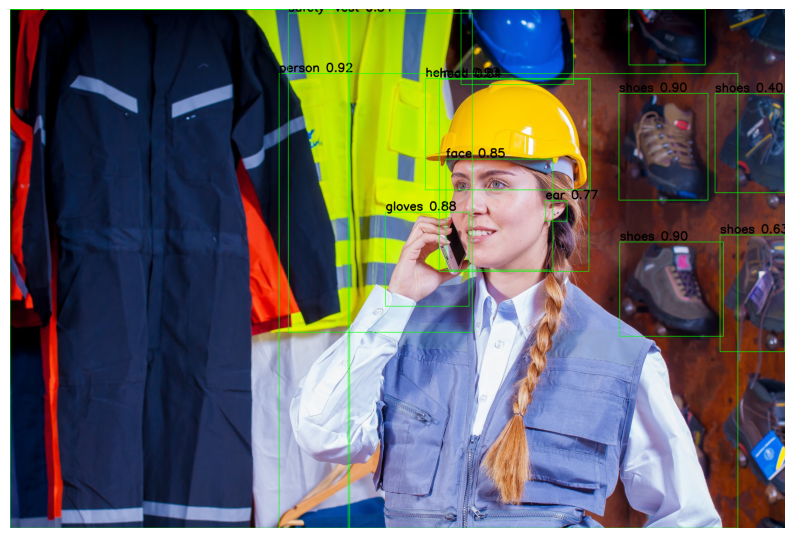

Detected violations: ['Safety vest detected but not worn properly']


In [45]:
violations = check_compliance('/kaggle/input/test-images/pexels-photo-209719.jpeg')
print("Detected violations:", violations)


0: 512x768 3 persons, 1 ear, 2 faces, 3 glovess, 2 helmets, 1 hand, 3 heads, 1 safety-suit, 24.3ms
Speed: 3.7ms preprocess, 24.3ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 768)


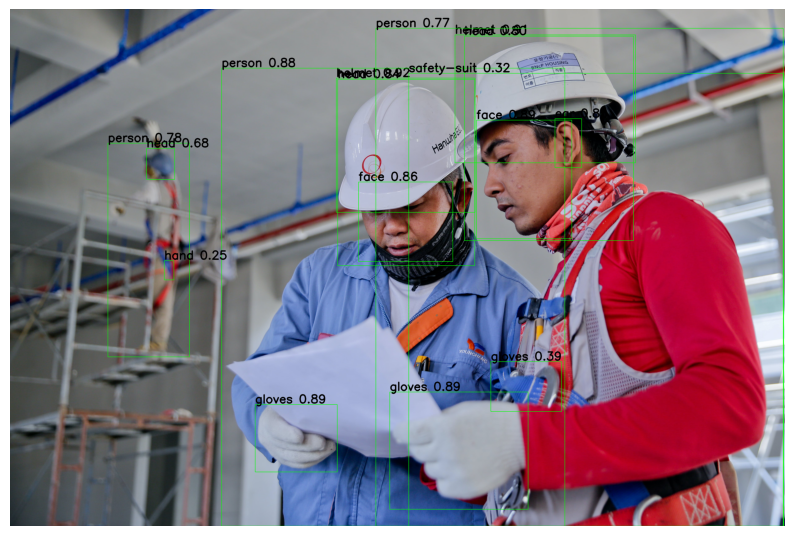

Detected violations: ['Safety vest missing from image']


In [46]:
violations = check_compliance('/kaggle/input/test-images/pexels-photo-1216589.jpeg')
print("Detected violations:", violations)


0: 512x768 2 persons, 1 gloves, 2 helmets, 2 heads, 4 shoess, 1 safety-vest, 23.6ms
Speed: 3.5ms preprocess, 23.6ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 768)


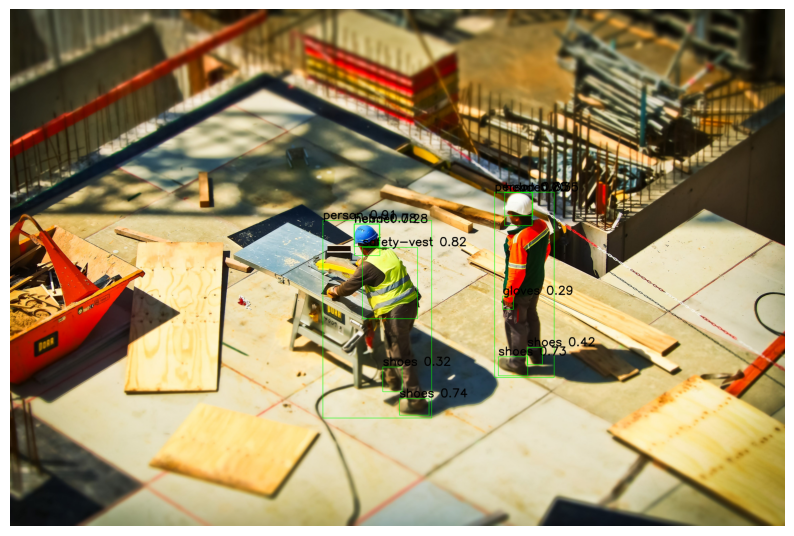

Detected violations: ['Safety suit missing from image']


In [47]:
violations = check_compliance('/kaggle/input/test-images/construction-site-build-construction-work-159306.jpeg')
print("Detected violations:", violations)


0: 768x512 1 person, 2 ears, 1 face, 1 glasses, 1 helmet, 2 hands, 1 head, 24.1ms
Speed: 4.2ms preprocess, 24.1ms inference, 1.4ms postprocess per image at shape (1, 3, 768, 512)


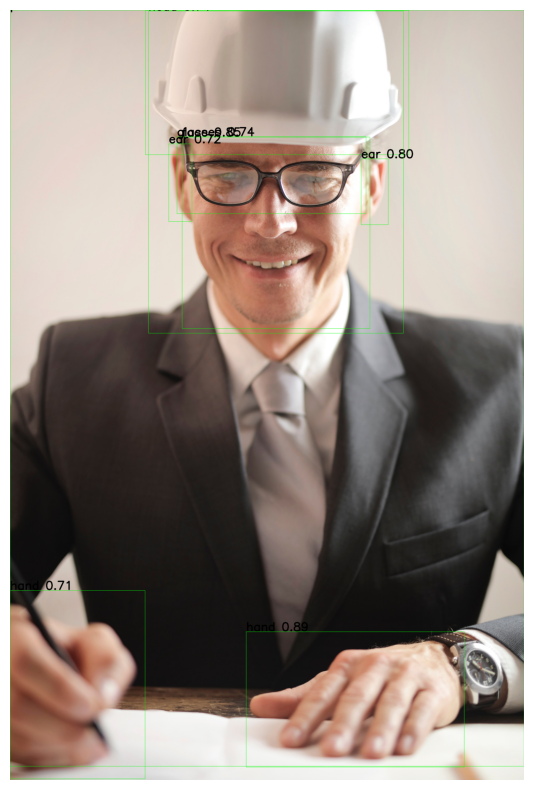

Detected violations: ['Gloves missing from image', 'Safety vest missing from image', 'Safety suit missing from image']


In [48]:
violations = check_compliance('/kaggle/input/test-images/pexels-photo-3769162.jpeg')
print("Detected violations:", violations)